<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Video-Based-Projects/blob/main/Human-Action-Recognition/MoViNet_hmdb51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install av
! wget https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 29.0 MB/s eta 0:00:00
--2024-01-17 02:20:30--  https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102 (3.0K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]   3.03K  --.-KB/s    in 0s      

2024-01-17 02:20:30 (44.0 MB/s) - ‘transforms.py’ saved [3102/3102]

--2024-01-17 02:20:30--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connec

In [2]:
pip install git+https://github.com/Atze00/MoViNet-pytorch.git


  Cloning https://github.com/Atze00/MoViNet-pytorch.git to /tmp/pip-req-build-ebj09t1d
  Running command git clone --filter=blob:none --quiet https://github.com/Atze00/MoViNet-pytorch.git /tmp/pip-req-build-ebj09t1d
  Resolved https://github.com/Atze00/MoViNet-pytorch.git to commit c2d1edf48fc6c5259707f9d833f22171b4f63493
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 840.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for MoViNet-pytorch: filename=MoViNet_pytorch-0.2.2-py3-none-any.whl size=11959 sha256=bcf95ae5acdfc4d9248ed35605a7c6063479bd296d43e8bedd4339b2fd5a9187
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmk1ahu5/wheels/a4/76/cf/b8a087460d770e5a44eff9ed975e225d43f007c8c14f8e26d2
  Created wheel f

In [3]:
# Extract and organize video data..
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar
! rm hmdb51_org.rar
! mv *.rar video_data
import os
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    os.system("mkdir -p video_data/" + foldername)
    os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  test_train_splits/brush_hair_test_split1.txt                   0%  OK 
Extracting  test_train_splits/brush_hair_test_split2.txt                   1%  OK 
Extracting  test_train_splits/brush_hair_test_split3.txt                   1%  OK 
Extracting  test_train_splits/cartwheel_test_split1.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split2.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split3.txt                    3%  OK 
Extracting  test_train_splits/catch_test_split1.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split2.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split3.txt                        5%  OK 
Extracting  test_train_splits/chew_test_split1.txt       

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [5]:
import time
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
import transforms as T
from movinets import MoViNet
from movinets.config import _C

torch.manual_seed(97)
num_frames = 16 # 16
clip_steps = 2
Bs_Train = 16
Bs_Test = 16

transform = transforms.Compose([

                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.RandomHorizontalFlip(),
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 T.RandomCrop((172, 172))])
transform_test = transforms.Compose([
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 T.CenterCrop((172, 172))])

hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=True,
                                                transform=transform, num_workers=2)


hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=transform_test, num_workers=2)
train_loader = DataLoader(hmdb51_train, batch_size=Bs_Train, shuffle=True)
test_loader  = DataLoader(hmdb51_test, batch_size=Bs_Test, shuffle=False)

100%|██████████| 423/423 [01:55<00:00,  3.66it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/video_utils.py:219: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(
100%|██████████| 423/423 [01:52<00:00,  3.76it/s]


In [6]:
hmdb51_classes = [
    'brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs',
    'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing',
    'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball',
    'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup',
    'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow',
    'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand',
    'swing_baseball', 'sword_exercise', 'sword_spinning', 'talk', 'throw',
    'turn', 'walk', 'wave'
]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


<class 'torch.Tensor'> torch.Size([3, 16, 172, 172])


,,,

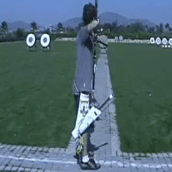
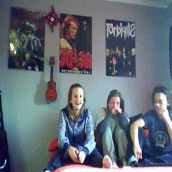
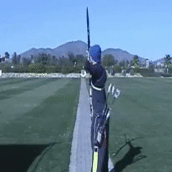
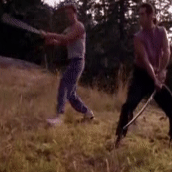

In [7]:
import pdb
!pip install -q mediapy
import mediapy as media

import numpy as np

data_iter = iter(train_loader)

# Fetch a single batch/item
single_item = next(data_iter)

#pdb.set_trace()
# Access the inputs and targets from the single item
input_vids, chk, targets = single_item

print(type(input_vids), input_vids[0].shape)

selected_videos = input_vids[:4]

reshaped_vids = np.transpose(selected_videos, (0, 2, 3, 4, 1))

media.show_videos(reshaped_vids.numpy(), codec='gif', fps=8)

cls_names = targets[:4]
print(f"class : ")
for i in cls_names:
  print(hmdb51_classes[i])

In [14]:
def train_iter(model, optimz, data_load, loss_val):
    samples = len(data_load.dataset)
    model.train()
    model.cuda()
    model.clean_activation_buffers()
    optimz.zero_grad()
    for i, (data,_ , target) in enumerate(data_load):
        out = F.log_softmax(model(data.cuda()), dim=1)
        loss = F.nll_loss(out, target.cuda())
        loss.backward()
        optimz.step()
        optimz.zero_grad()
        model.clean_activation_buffers()
        if i % 50 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_val.append(loss.item())

def evaluate(model, data_load, loss_val):
    model.eval()

    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    model.clean_activation_buffers()
    with torch.no_grad():
        for data, _, target in data_load:
            output = F.log_softmax(model(data.cuda()), dim=1)
            loss = F.nll_loss(output, target.cuda(), reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target.cuda()).sum()
            model.clean_activation_buffers()
    aloss = tloss / samples
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

def train_iter_stream(model, optimz, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    """
    In causal mode with stream buffer a single video is fed to the network
    using subclips of lenght n_clip_frames.
    n_clips*n_clip_frames should be equal to the total number of frames presents
    in the video.

    n_clips : number of clips that are used
    n_clip_frames : number of frame contained in each clip
    """
    #clean the buffer of activations
    samples = len(data_load.dataset)
    model.cuda()
    model.train()
    model.clean_activation_buffers()
    optimz.zero_grad()

    for i, (data,_, target) in enumerate(data_load):
        data = data.cuda()
        target = target.cuda()
        l_batch = 0
        #backward pass for each clip
        for j in range(n_clips):
          output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
          loss = F.nll_loss(output, target)
          _, pred = torch.max(output, dim=1)
          loss = F.nll_loss(output, target)/n_clips
          loss.backward()
        l_batch += loss.item()*n_clips
        optimz.step()
        optimz.zero_grad()

        #clean the buffer of activations
        model.clean_activation_buffers()
        if i % 50 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(l_batch))
            loss_val.append(l_batch)

def evaluate_stream(model, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    model.eval()
    model.cuda()
    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    ground_truths = []
    all_preds = []
    with torch.no_grad():
        for data, _, target in data_load:
            data = data.cuda()
            target = target.cuda()
            temp = target
            ground_truths.append(temp.tolist())
            model.clean_activation_buffers()
            for j in range(n_clips):
              output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
              loss = F.nll_loss(output, target)
            _, pred = torch.max(output, dim=1)
            temp = pred
            all_preds.append(temp.tolist())
            tloss += loss.item()
            csamp += pred.eq(target).sum()

    aloss = tloss /  len(data_load)
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

    gt_list = [item for sublist in ground_truths for item in sublist]
    pred_list = [item for sublist in all_preds for item in sublist]
    cm = confusion_matrix(gt_list, pred_list, labels=range(51), normalize= 'true')
    plt.figure(figsize=(30, 30))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 51)), labels=hmdb51_classes, rotation= 90)
    plt.yticks(list(range(0, 51)), labels=hmdb51_classes)
    plt.colorbar(ctx)
    plt.show()
    print(classification_report(gt_list, pred_list))

Epoch: 1


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


[    0/ 7520 (  0%)]  Loss: 3.9507
[  800/ 7520 ( 11%)]  Loss: 3.4984
[ 1600/ 7520 ( 21%)]  Loss: 2.9690
[ 2400/ 7520 ( 32%)]  Loss: 2.1817
[ 3200/ 7520 ( 43%)]  Loss: 2.0190
[ 4000/ 7520 ( 53%)]  Loss: 1.0637
[ 4800/ 7520 ( 64%)]  Loss: 1.4503
[ 5600/ 7520 ( 74%)]  Loss: 0.9494
[ 6400/ 7520 ( 85%)]  Loss: 0.7634
[ 7200/ 7520 ( 96%)]  Loss: 0.9945

Average test loss: 1.3588  Accuracy: 2070/ 2945 (70.29%)



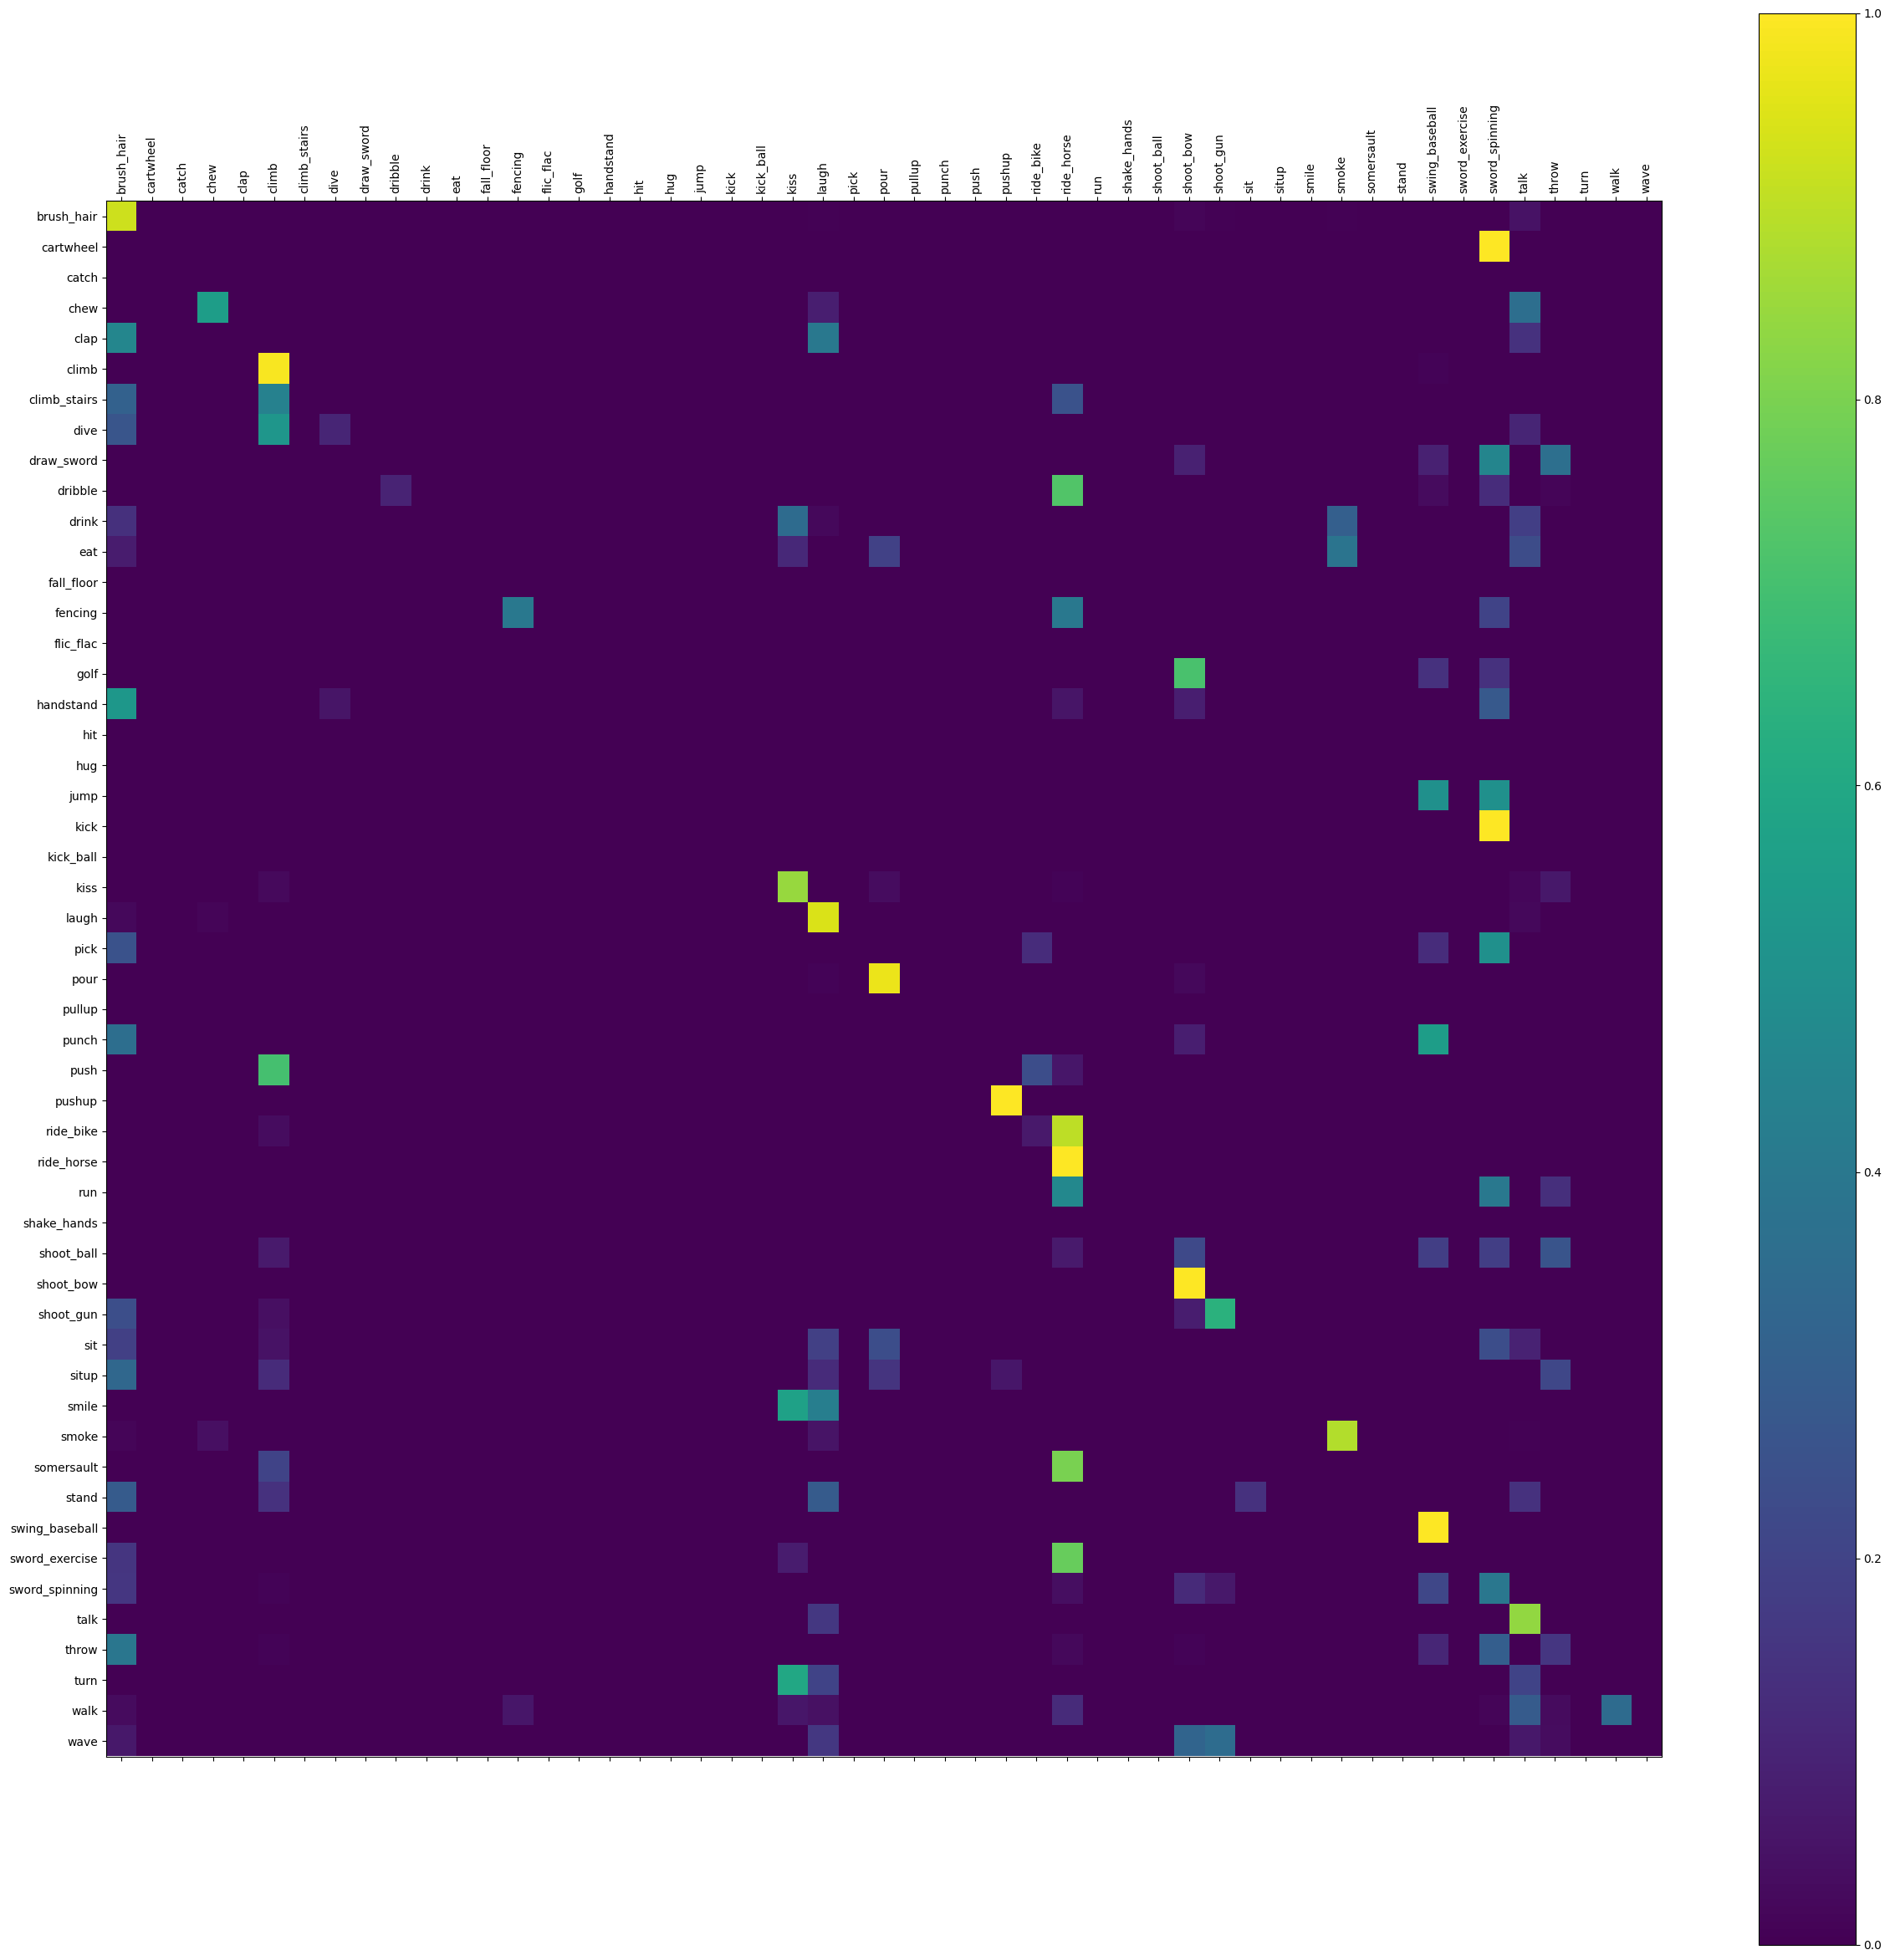

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       508
           1       0.00      0.00      0.00         4
           3       0.67      0.56      0.61        36
           4       0.00      0.00      0.00        35
           5       0.81      0.99      0.89       205
           6       0.00      0.00      0.00        16
           7       0.40      0.11      0.17        19
           8       0.00      0.00      0.00        11
           9       1.00      0.10      0.18        70
          10       0.00      0.00      0.00        43
          11       0.00      0.00      0.00        26
          13       0.50      0.40      0.44        10
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00        36
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         2
          22       0.89      0.85      0.87       287
          23       0.80    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
N_EPOCHS = 1

model = MoViNet(_C.MODEL.MoViNetA0, causal = True, pretrained = True )
start_time = time.time()

trloss_val, tsloss_val = [], []
model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
optimz = optim.Adam(model.parameters(), lr=0.00005)
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_iter_stream(model, optimz, train_loader, trloss_val)
    evaluate_stream(model, test_loader, tsloss_val)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

In [ ]:
weights_path = 'stream_weights.pth'
torch.save(model.state_dict(), weights_path)

In [ ]:
model = MoViNet(_C.MODEL.MoViNetA0, causal = True, pretrained = True )

trloss_val, tsloss_val = [], []
model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
optimz = optim.Adam(model.parameters(), lr=0.00005)

weights_path = 'stream_weights.pth'
# Load the saved weights into the model for streaming case
model.load_state_dict(torch.load(weights_path))


In [ ]:
n_clips = 2
n_clip_frames=8

data_iter = iter(test_loader)
for i in range(20):
  single_item = next(data_iter)


with torch.no_grad():
  data, _, target = single_item

  print(type(target))
  pdb.set_trace()
  model.clean_activation_buffers()
  for j in range(n_clips):
    output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)

  _, pred = torch.max(output, dim=1)

data = data.cpu()
selected_videos = data[:8]

reshaped_vids = np.transpose(selected_videos, (0, 2, 3, 4, 1))

media.show_videos(reshaped_vids.numpy(), codec='gif', fps=8)

cls_names = pred[:8]
print(f"class : ")
print(f"Ground Truth : {target[:8]}")
for i in cls_names:
  print(hmdb51_classes[i])

In [ ]:
N_EPOCHS = 1

model = MoViNet(_C.MODEL.MoViNetA0, causal = False, pretrained = True )
start_time = time.time()

trloss_val, tsloss_val = [], []
model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
optimz = optim.Adam(model.parameters(), lr=0.00005)
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_iter(model, optimz, train_loader, trloss_val)
    evaluate(model, test_loader, tsloss_val)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')